# Getting started with packages imports and git repo cloning

Ref : https://github.com/BojarLab/SweetNet/blob/main/SweetNet_code.ipynb
https://medium.com/mantisnlp/how-to-combine-several-embeddings-models-8e7bc9a00330
https://distill.pub/2021/gnn-intro/
https://bojarlab.github.io/glycowork/glycan_data.html
https://www.sciencedirect.com/science/article/pii/S2211124721006161#sec1
https://academic.oup.com/glycob/article/31/10/1240/6311240#312815562

In [3]:
!git clone -b phi https://github.com/PhiCtl/isospec-internship/

Cloning into 'isospec-internship'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 215 (delta 88), reused 153 (delta 42), pack-reused 0 (from 0)
Receiving objects: 100% (215/215), 12.49 MiB | 10.84 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [ ]:
!pip install "glycowork[ml]" nbdev glycowork

In [5]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML
from nbdev.showdoc import show_doc

import numpy as np
import pandas as pd
import os

from torch_geometric.nn import TopKPooling, GraphConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
import torch

from glycowork.ml.models import *
from glycowork.ml.inference import *
from glycowork.ml.processing import *
from glycowork.ml.model_training import *
from glycowork.ml.train_test_split import *
from glycowork.glycan_data.loader import df_species, df_glycan, glycan_binding

In [6]:
DATA_PATH = "/content/isospec-internship/data/glycan_embedding"

# Datasets

In [14]:
# Extracted glycans used for inference and enrichment
df_glycan_list = pd.read_csv(os.path.join(DATA_PATH, 'glycan_list.csv'))
df_glycan_list

,glycan,Composition,tissue_species,tissue_sample
0,Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man...,"{'dHex': 2, 'HexNAc': 4, 'Hex': 3}",['Homo_sapiens'],['blood']
1,Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,"{'Neu5Ac': 1, 'Hex': 4, 'HexNAc': 4, 'dHex': 1}",['Homo_sapiens'],['blood']
2,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal...,"{'Neu5Ac': 1, 'Hex': 5, 'HexNAc': 4}",['Homo_sapiens'],['blood']
3,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,"{'Neu5Ac': 1, 'Hex': 4, 'HexNAc': 4}",['Homo_sapiens'],['blood']
4,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,"{'dHex': 1, 'HexNAc': 5, 'Hex': 5}",['Homo_sapiens'],['blood']


In [13]:
df_glycan[['glycan', 'disease_association']].head()
#df_glycan.columns

,glycan,disease_association
0,Gal(b1-4)Glc-ol,[]
1,Neu5Ac(a2-3)Gal(b1-4)Glc1Cer,"[cataract, lung_small_cell_carcinoma, melanoma]"
2,Glc1Cer,[melanoma]
3,Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Gal(b1-4)GlcNAc...,"[Crohn_disease, Lyme_disease, colorectal_cance..."
4,Man(a1-2)Man(a1-3)[Man(a1-3)[Man(a1-6)]Man(a1-...,"[Toxoplasma_gondii_infection, chronic_low_back..."


In [9]:
glycan_binding.head()

,3-Anhydro-Gal(a1-3)Gal(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal2S(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3dGal(b1-3)[Fuc(a1-4)]Glc,3dGal(b1-4)Glc,4d8dNeu5Ac(a2-3)Gal(b1-4)Glc,4dNeu5Ac(a2-3)Gal(b1-4)Glc,7dNeu5Ac(a2-3)Gal(b1-4)Glc,...,wwwSflexneri5c,wwwSflexneriO2c,wwwSflexneriO5c,wwwSisomicin,wwwSmix,wwwTobramycin,wwwTyrS,wwwpHGGs,target,protein
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AADSIPSISPTGIITPTPTQSGMVSNCNKFYDVHSNDGCSAIASSQ...,TAL6-4LysM
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAFFSLVVLLALLPFGIHASALPSTELTPRVNPNLPGPNDVFVGFR...,rCnSL-proA
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AANEADYQAKLTAYQTELARVQKANADAKAAYEAAVAANNAANAAL...,AntigenI/IIA3VP1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AASKLGVPQPAQRDQVNCQLYAVQPNDNCIDISSKNNITYAQLLSW...,TAL6-6LysM
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ACNNEWEDEQYEQYISFKSPIPAGGEGVTDIYVRYKEDGKVTYRLP...,SP15308A-bot-339-19-339


In [8]:
# Used to control representation in the embedding space by assessing closeness
df_N_glycans = pd.read_csv(os.path.join(DATA_PATH, 'N_glycans_df.csv'))
df_N_glycans.head()

,glycan,Species,Genus,Family,Order,Class,Phylum,Kingdom,Domain,ref,...,disease_sample,disease_direction,disease_ref,disease_species,tissue_sample,tissue_id,tissue_ref,tissue_species,Composition,Structure_Type
0,Neu5Ac(a2-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal...,"['Cricetulus_griseus', 'Homo_sapiens', 'Mus_mu...","['Cricetulus', 'Homo', 'Mus', 'Ovis', 'Rattus']","['Cricetidae', 'Hominidae', 'Muridae', 'Bovida...","['Rodentia', 'Primates', 'Rodentia', 'Artiodac...","['Mammalia', 'Mammalia', 'Mammalia', 'Mammalia...","['Chordata', 'Chordata', 'Chordata', 'Chordata...","['Animalia', 'Animalia', 'Animalia', 'Animalia...","['Eukarya', 'Eukarya', 'Eukarya', 'Eukarya', '...","['', '', 'https://unicarb-dr.glycosmos.org/ref...",...,[],[],[],[],"['2A3_cell_line', 'AML_193_cell_line', 'Cal-27...","['cellosaurus:CVCL_0D71', 'cellosaurus:CVCL_10...","['https://pubmed.ncbi.nlm.nih.gov/36289103/', ...","['Homo_sapiens', 'Homo_sapiens', 'Homo_sapiens...","{'Neu5Ac': 1, 'Hex': 5, 'HexNAc': 4}",Complex_Gal
1,Gal(a1-3)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal(b1...,"['Bos_taurus', 'Ginglymostoma_cirratum', 'Mus_...","['Bos', 'Ginglymostoma', 'Mus', 'Sus']","['Bovidae', 'Ginglymostomatidae', 'Muridae', '...","['Artiodactyla', 'Orectolobiformes', 'Rodentia...","['Mammalia', 'Chondrichthyes', 'Mammalia', 'Ma...","['Chordata', 'Chordata', 'Chordata', 'Chordata']","['Animalia', 'Animalia', 'Animalia', 'Animalia']","['Eukarya', 'Eukarya', 'Eukarya', 'Eukarya']","['', 'https://pubmed.ncbi.nlm.nih.gov/19156518...",...,[],[],[],[],[],[],[],[],"{'Hex': 6, 'HexNAc': 4}",Complex_Gal
2,Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal...,"['Notamacropus_eugenii', 'Homo_sapiens', 'Homo...","['Notamacropus', 'Homo', 'Homo']","['Macropodidae', 'Hominidae', 'Hominidae']","['Diprotodontia', 'Primates', 'Primates']","['Mammalia', 'Mammalia', 'Mammalia']","['Chordata', 'Chordata', 'Chordata']","['Animalia', 'Animalia', 'Animalia']","['Eukarya', 'Eukarya', 'Eukarya']","['https://pubmed.ncbi.nlm.nih.gov/23053637/', ...",...,"['', '']","['', '']","['', '']","['', '']","['urine', 'urine']","['UBERON:0001088', 'UBERON:0001088']","['https://pubmed.ncbi.nlm.nih.gov/33650863/', ...","['Homo_sapiens', 'Homo_sapiens']","{'Neu5Ac': 1, 'Hex': 5, 'HexNAc': 4}",Complex_Gal
3,Fuc(a1-2)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal(b1...,['Homo_sapiens'],['Homo'],['Hominidae'],['Primates'],['Mammalia'],['Chordata'],['Animalia'],['Eukarya'],[''],...,[],[],[],[],['plasma'],['ENVO:01000798'],['https://pubmed.ncbi.nlm.nih.gov/1577715/'],['Homo_sapiens'],"{'dHex': 1, 'Hex': 5, 'HexNAc': 4}",Complex_Gal
4,Fuc(a1-2)[Gal(a1-3)]Gal(b1-4)GlcNAc(b1-2)Man(a...,['Homo_sapiens'],['Homo'],['Hominidae'],['Primates'],['Mammalia'],['Chordata'],['Animalia'],['Eukarya'],[''],...,[],[],[],[],['plasma'],['ENVO:01000798'],['https://pubmed.ncbi.nlm.nih.gov/1577715/'],['Homo_sapiens'],"{'dHex': 1, 'Hex': 6, 'HexNAc': 4}",Complex_Gal


# Approaches reflexion

Getting inspiration from [Using graph convolutional neural networks to learn a representation for glycans](https://www.sciencedirect.com/science/article/pii/S2211124721006161#sec1) :
* Sweetnet is a graph convolutional network (GCNN) that provides a useful glycan representation using glycan sequence.
* Sweetnet was trained using _the task of predicting which species a given glycan sequence came from_, ie. a multiclass classification task : See more about Sweetnet training [here](https://github.com/BojarLab/SweetNet/blob/main/SweetNet_code.ipynb) for a better model performance comparison. The GCNN approach outperformed existing approaches on the classification task.
* Sweetnet was also pretrained using _a context prediction task in which the model is used to predict the identity of a randomly chosen hidden node, given the connectivities and the other nodes in a glycan_ before being fine-tuned on the classification task.


Different approaches can be considered:
* Take advantage of already trained Sweetnet to infer glycan embedding and assess closeness to other structures.
* Take advantage of curated Sweetnet architecture for glycan sequence embedding, train the model on human tissues collected glycans with the task of predicting the associated diseases.
* ``` composition ``` and ```tissue_sample``` features could be leveraged for embedding space learning as well, but 1) ```composition``` is redundant with the glycan sequence and 2) ```tissue_sample``` might not exactly reflect glycan presence in tissues.



# 1 - Using already trained Sweetnet for embedding inference

## Embedding inference

In [55]:
model = prep_model('SweetNet', trained=True, num_classes=1011)
glycans = df_glycan_list['glycan'].to_numpy()

df_learned_rep = glycans_to_emb(glycans, model)
df_learned_rep['glycan'] = df_glycan_list['glycan']
df_learned_rep['type'] = ['unknown'] * len(df_learned_rep)
df_learned_rep.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,glycan,type
0,-0.794141,-0.075739,-0.099164,0.726709,0.484261,0.070893,-0.756495,-0.204407,0.055970,-0.106668,...,0.481233,0.159814,0.675465,0.173172,0.157147,-0.082025,-0.173163,-0.449195,Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man...,unknown
1,-0.649488,-0.155966,0.530374,0.360211,0.247192,-0.063482,-0.621762,-0.005740,0.590882,0.361569,...,-0.070064,-0.821788,0.703040,0.204986,0.109358,-0.139274,0.202473,-0.726340,Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,unknown
2,-0.574490,-0.104016,-0.097022,0.506985,0.128725,-0.525511,-0.147155,-0.002637,0.141030,0.261282,...,0.409167,-0.540376,-0.123692,0.397333,0.210452,-0.353647,0.439389,-0.438737,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal...,unknown
3,-0.710714,0.032202,-0.282863,0.587875,0.076552,-0.778691,-0.137108,-0.072778,-0.031902,0.353800,...,0.508384,-0.626425,-0.098453,0.369425,0.176167,-0.452234,0.467732,-0.455070,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,unknown
4,-0.673734,0.372436,-0.098899,0.576457,0.379759,0.199676,-0.296904,0.052517,0.298454,0.545761,...,0.185924,0.356945,0.357075,0.143403,0.357225,0.297999,0.403833,-0.739957,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,unknown


In [48]:
human_glycans = df_glycan.explode('tissue_species')
human_glycans = human_glycans[human_glycans['tissue_species'] == 'Homo_sapiens']
glycans_exhaustive = human_glycans['glycan'].to_numpy()
df_learned_rep_exhaustive = glycans_to_emb(glycans_exhaustive, model)
df_learned_rep_exhaustive['glycan'] = human_glycans['glycan'].to_numpy()
df_learned_rep_exhaustive['type'] = ['known'] * len(df_learned_rep_exhaustive)

In [72]:
df_learned_rep_exhaustive.shape

(8599, 130)

In [56]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

tsne_emb = TSNE(random_state = 42).fit_transform(pd.concat([df_learned_rep_exhaustive, df_learned_rep]).drop(['glycan', 'type'], axis=1))

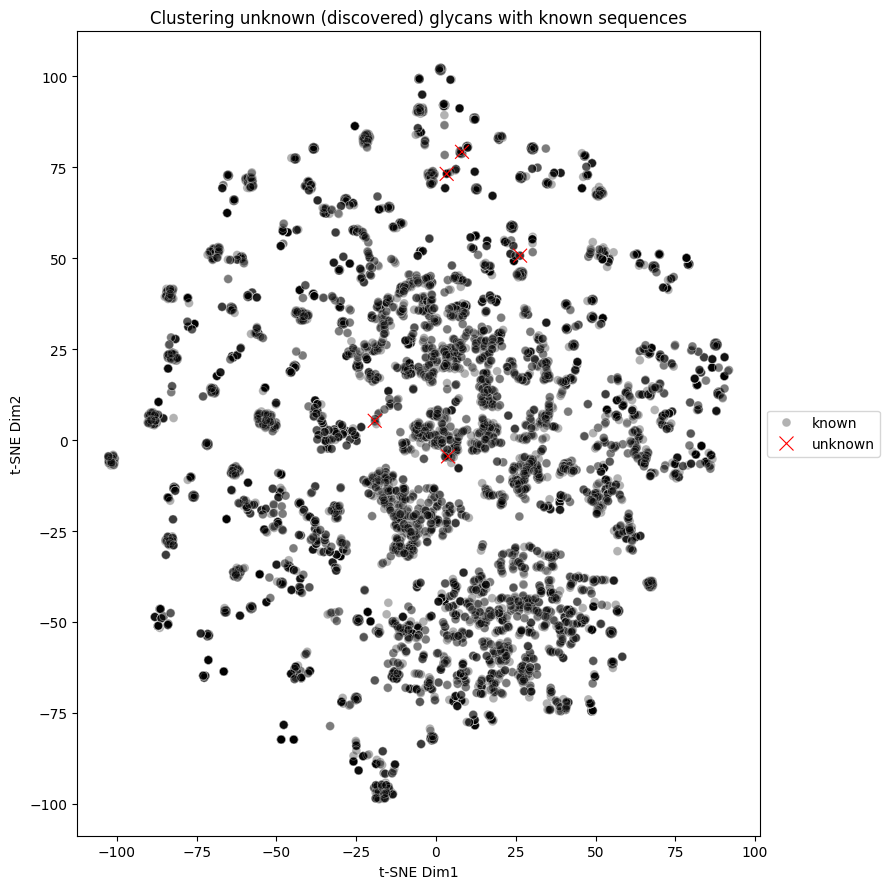

In [71]:
plt.figure(figsize = (9, 9))
sns.scatterplot(x = tsne_emb[:-5,0], y = tsne_emb[:-5,1], s = 40, alpha = 0.3,
                hue = df_learned_rep_exhaustive['type'].values.tolist(), palette=['black'])
sns.scatterplot(x = tsne_emb[-5:,0], y = tsne_emb[-5:,1], s = 100,
                hue = df_learned_rep['type'].values.tolist(), marker='x', palette=['red'])
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('t-SNE Dim1')
plt.ylabel('t-SNE Dim2')
plt.title('Clustering unknown (discovered) glycans with known sequences')
plt.tight_layout()

## Cluster data points

Using learned embeddings, find which clusters the 5 glycans of interest belong to.
One challenge is that data points have a high number of dimensions so we have to take care of the choice of the clustering algorithm.